# Market Areas Indicators creations using Raster Data

## Create market areas

### How does it work?

Considering the initial reference point (the centroid) of the market, a market with a radius `r` is generated, which is represented within a square, taking into account the width of the `grid` (in km) that you want to calculate.


In [1]:
import requests, pandas as pd, alphashape
from tqdm import tqdm
import geopandas as gpd, numpy as np
from shapely.geometry import LineString, Point
from shapely.geometry import Polygon
import geopy.distance
import warnings 
import pandas as pd, numpy as np
import geopandas as gpd, rasterio as rio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd, numpy as np
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')

ecl_dist = geopy.distance.geodesic

crs_moll='EPSG:3857'
crs_lat='EPSG:4326'

# Download PBF file
from osrmareas.downloader import GetPBF
download = GetPBF()
download.country(['pakistan']).get(save_dir='countr_pk')

pbf_file = 'pakistan-latest.osm' #{country, subregion}-latest.osm
pbf_file_path = './countr_pk'

from osrmareas.osrm import Server
pk_server = Server(pbf_file, pbf_file_path)

# Generate the files
pk_server.gen_osrm_1()
pk_server.prepare_server_2()

# Run the server locally
pk_server.run_server()


n = 1  

def save_plot(name = ""):
    name = name.lower()
    global n  
    num_fig = str(n).zfill(2)
    n += 1  
    file_name = f"../figures/{num_fig}_{name}.png"
    print(file_name)
    plt.savefig(file_name)
# Define a function to extract features compatible with rasterio
def getFeatures(gdf: gpd.GeoDataFrame):
    import json

    return [json.loads(gdf.to_json())["features"][0]["geometry"]]

Convert the country names to lowercase and replace spaces with dashes (-).
source: https://download.geofabrik.de/
Please run the following function only once for each .pbf file. (It takes some time to execute, and consume all the CPU)
Found ./countr_pk\pakistan-latest.osrm file
Done, generate a osrm file
Please run the following function only once for each .pbf file. (It takes some time to execute, and consume all the CPU)
Done, I have generated the local OSRM server with `{server}.run_server()`.
The server is running in the background, you can start making queries.


For example, if we slightly modify the code from [`make_grid`](https://github.com/alexanderquispe/osrm_python/blob/main/osrmareas/areas.py)

In [2]:
import matplotlib.pyplot as plt


def destination(x, y, size_grid):
    coords_pol = [
        (x, y),
        (x + size_grid, y),
        (x + size_grid, y + size_grid),
        (x, y + size_grid),
    ]
    center = size_grid / 2
    coords_center = [x + center, y + center]
    return coords_center

from_ =[24.910871, 67.030846]

def generate_grid(center_lat_long = from_ , radius_km=5, name='', grid_km_size=2.5, show:bool = False):

    n_grid = radius_km / grid_km_size * 2

    center = list(reversed(center_lat_long))
    radius_km = radius_km * 1000
    initial_center = Point(center)

    point_c = gpd.GeoSeries(initial_center, crs=crs_lat).to_crs(crs_moll)
    point_center = point_c.buffer(radius_km, cap_style=3)

    minX, minY, maxX, maxY = point_center.total_bounds
    size_grid_km = (maxY - minY) / n_grid
    cols_grid = list(np.arange(minX, maxX, size_grid_km))
    rows_grid = list(np.arange(minY, maxY, size_grid_km))

    x_destinations = []
    y_destinations = []

    plt.figure(figsize=(6, 6))

    for x in cols_grid:
        for y in rows_grid:
            final = destination(x, y, size_grid_km)
            x_destinations.append(final[0])
            y_destinations.append(final[1])

    print(len(y_destinations))
    if show:
        return(x_destinations, y_destinations)


    ax = plt.gca()
    point_c_moll = point_c.bounds[["minx", "miny"]].T.values

    for i in range(len(cols_grid)):
        plt.axhline(y=rows_grid[i])
        plt.axvline(x=cols_grid[i])

    plt.scatter(point_c_moll[0][0], point_c_moll[1][0], color="red", s=200)

    plt.scatter(x_destinations, y_destinations)
    plt.axis("off")

    ax.set_xlim((minX, maxX))
    ax.set_ylim((minY, maxY))
    save_plot(name)
    # return ax


In the provided code snippets, the function `generate_grid` is called with different parameters to create grids for different market scenarios. Let's elaborate on each scenario:

- For a market with a radius of 5km and a grid size of 2.5km:


16
../figures/01_grid_5_2.5.png


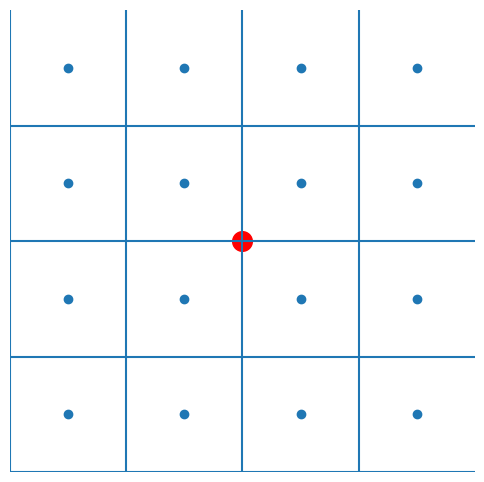

In [3]:
p1 = generate_grid(radius_km=5, grid_km_size=2.5, name='grid_5_2.5')
p1

This function call generates a grid where each grid cell covers an area of 2.5km x 2.5km within the 5km radius of the market. With this configuration, there would be 16 final destination points.

- For a market with a radius of 5km and a grid size of 1km:

100
../figures/02_grid_5_1.png


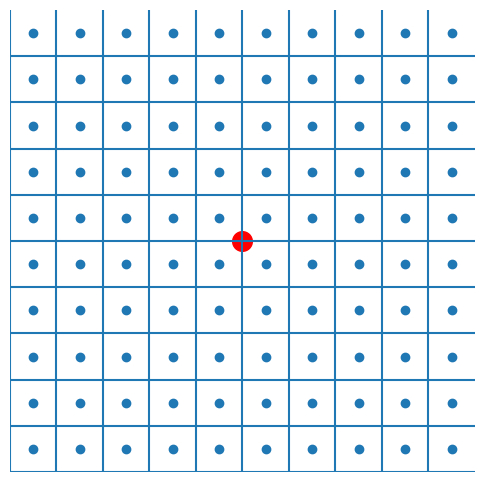

In [4]:
generate_grid(radius_km=5, grid_km_size=1, name='grid_5_1')

In this scenario, each grid cell covers an area of 1km x 1km within the 5km radius. Consequently, there would be 100 final destination points. 
Including the routes

400


100%|██████████| 400/400 [00:02<00:00, 167.53it/s]


../figures/03_grid_with_routes.png


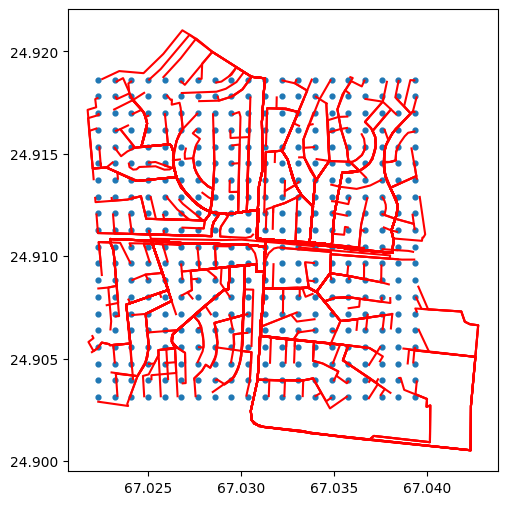

In [5]:
from osrmareas import areas
x, y = generate_grid(radius_km=1, grid_km_size=0.1, show=True)
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x, y)).set_crs(crs_moll).to_crs(crs_lat)
x, y = gdf.geometry.x.values, gdf.geometry.y.values
plt.scatter(x, y, s=12)
gdf_area = areas.get_routes(from_, filter_km=False, radius_km=1, grid_km_size=0.1)
gdf_area.plot(ax=plt.gca(), edgecolor = 'red')
save_plot(name="Grid_with_routes")

100%|██████████| 400/400 [00:02<00:00, 169.09it/s]


../figures/04_grid_with_range_routes.png


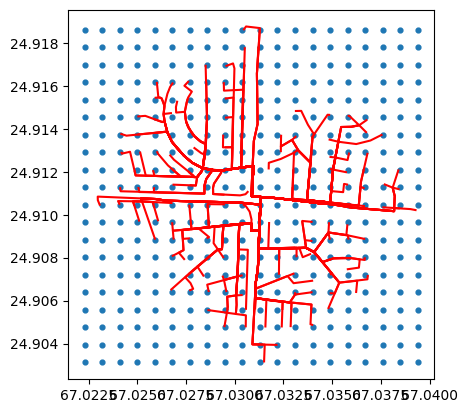

In [6]:
plt.scatter(x, y, s=12)
gdf_area_filter = areas.get_routes(from_, filter_km=True, radius_km=1, grid_km_size=0.1)
gdf_area_filter.plot(ax=plt.gca(), edgecolor = 'red')
save_plot(name='grid_with_range_routes')

../figures/05_grid_with_final_routes.png

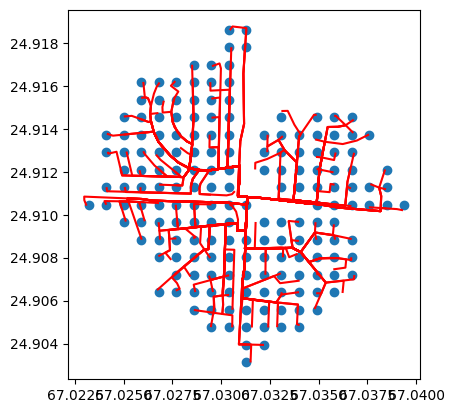

In [7]:
plt.scatter("dest_lat", 'dest_lon', data = gdf_area_filter)
gdf_area_filter.plot(ax=plt.gca(), edgecolor = 'red')
save_plot(name="grid_with_final_routes")

../figures/06_grid_shapefile.png


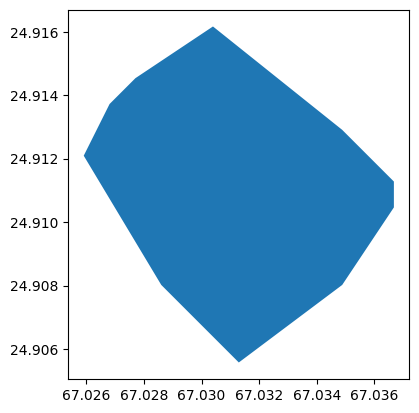

In [8]:
areas.get_ameba(gdf_area_filter).plot()
save_plot("grid_shapefile")

../figures/07_shapefile_routes_destination.png


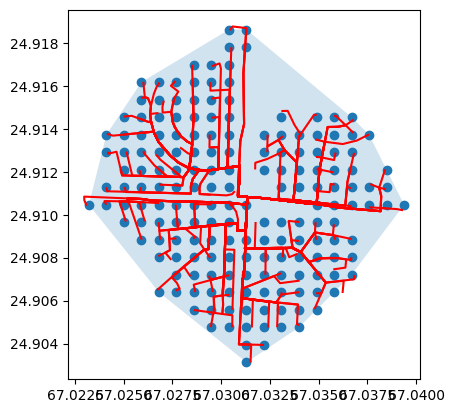

In [9]:
plt.scatter("dest_lat", 'dest_lon', data = gdf_area_filter)
gdf_area_filter.plot(ax=plt.gca(), edgecolor = 'red')
areas.get_ameba(gdf_area_filter, max_km=1).plot(ax=plt.gca(), alpha = 0.2)
save_plot('shapefile_routes_destination')

This call results in a grid where each grid cell covers an area of 100m x 100m within a 1km radius. Hence, there would be 400 final destination points.

These function calls demonstrate how adjusting the grid size affects the granularity of the grid and consequently the number of final destination points within a given market radius.

The provided code utilizes the OSRM Directions API through the `osrm_python` package to perform route calculations and visualize them. Let's break down the code and its functionalities:

### Setting Up OSRM Directions API with [`osrm_python`](https://github.com/alexanderquispe/osrm_python/tree/main?tab=readme-ov-file#osrm-routes) package

To use the library, you need to have the OSRM server running. For this specific case, a PBF file of Pakistan is used.

In [10]:
# Download PBF file
from osrmareas.downloader import GetPBF
download = GetPBF()
download.country(['pakistan']).get(save_dir='countr_pk')

pbf_file = 'pakistan-latest.osm' #{country, subregion}-latest.osm
pbf_file_path = './countr_pk'

from osrmareas.osrm import Server
pk_server = Server(pbf_file, pbf_file_path)

Convert the country names to lowercase and replace spaces with dashes (-).
source: https://download.geofabrik.de/


### Generating OSRM Files and Running the Server

The following code generates the necessary files for OSRM and starts the local server.

In [11]:
# Generate the files
# pk_server.gen_osrm_1()
# pk_server.prepare_server_2()

# # Run the server locally
# pk_server.run_server()

### Calculating Routes and Visualizing

The code snippet below calculates a route from a starting point (`from_`) to an ending point (`to_`) and plots it on a map.

In [12]:
from osrmareas import areas
from_ = [28.421612, 70.313059]
to_ = [28.408835, 70.327077]
rt = areas.get_osrm_route(from_, to_)
rt

,geometry,dist_driving_km,dist_eucl_km,dest_lon,dest_lat,origin_lon,origin_lat
0,"LINESTRING (70.31306 28.42161, 70.31306 28.421...",2.7467,1.972733,28.408835,70.327077,28.421612,70.313059


../figures/08_simple_route.png


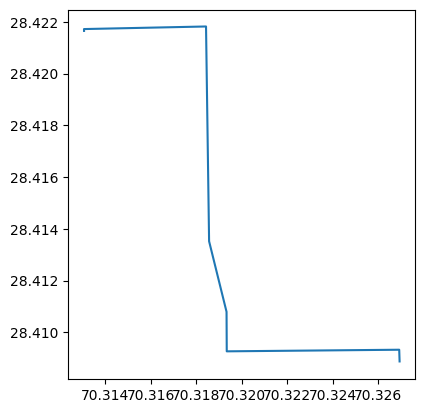

In [13]:
rt.plot()
save_plot("simple_route")

### Illustrating Grid Routes

The subsequent code snippets demonstrate route calculations and visualizations for different grid configurations:

1. Radius of 5km and grid size of 2.5km:

100%|██████████| 16/16 [00:00<00:00, 125.48it/s]


../figures/09_routes_5km_2-5km.png


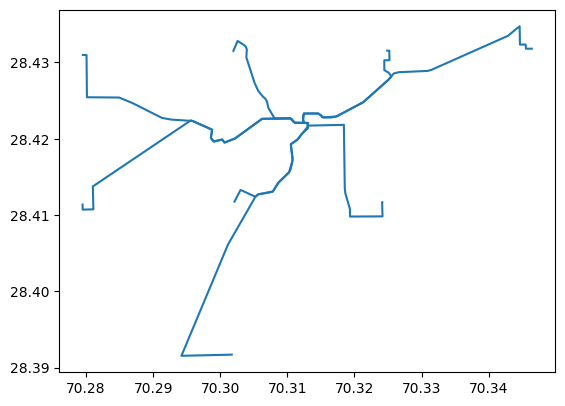

In [14]:
all_rt_1=areas.get_routes(from_, radius_km=5, grid_km_size= 2.5)
all_rt_1.plot()
save_plot("routes_5km_2-5km")

2. Radius of 5km and grid size of 1km:

100%|██████████| 100/100 [00:00<00:00, 133.62it/s]


../figures/10_routes_5km_1km.png


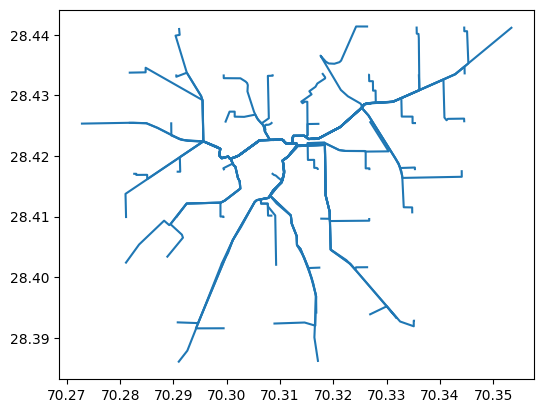

In [15]:
all_rt_2=areas.get_routes(from_, radius_km=5, grid_km_size= 1)
all_rt_2.plot()
save_plot("routes_5km_1km")

3. Radius of 1km and grid size of 100 meters:

100%|██████████| 400/400 [00:02<00:00, 171.73it/s]


../figures/11_routes_1km_0-1km.png


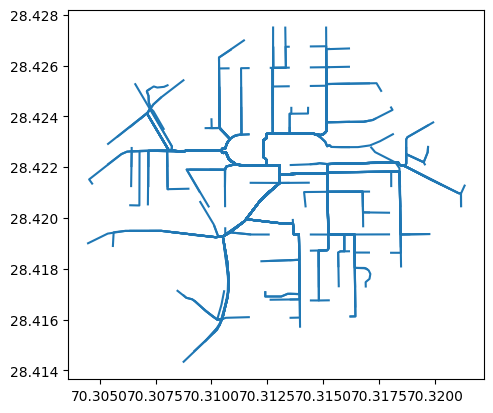

In [16]:
all_rt_3=areas.get_routes(from_, radius_km=1, grid_km_size= 0.1)
all_rt_3.plot()
save_plot(name="routes_1km_0-1km")

### Extracting Routes within a Specific Distance

Lastly, the code snippet below extracts routes within a specified distance and generates a shapefile representing a market from the centroid of a specific radius.

100%|██████████| 1600/1600 [00:13<00:00, 116.32it/s]


../figures/12_area_shapefile.png


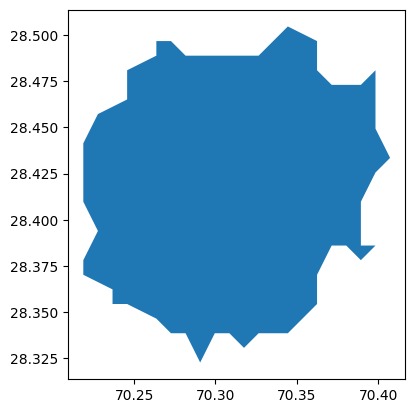

In [17]:
all_rt_3=areas.get_routes(from_, radius_km=20, grid_km_size= 1)
ameba = areas.get_ameba(all_rt_3, max_km = 12, alpha = 80, km_col='dist_driving_km')
ameba.plot()
save_plot("area_shapefile")

This code snippet demonstrates the capabilities of the `osrm_python` package for route calculation and visualization, particularly useful for market analysis and planning.

### OSM vs Google Maps API

Let's first provide some context for our case. We have approximately 250 markets, each with a radius of about 10km, and the width of the final destination search grid is 100 meters. This means we have 4000 search destinations per market. So, in total, we would have 4000 destinations multiplied by 250 markets, resulting in 1,000,000 destinations.

When using the Google Maps API, we have several options to choose from. However, for this case, the required service to subscribe to would be the [SKU: Router: Compute Routes - Basic](https://developers.google.com/maps/documentation/routes/usage-and-billing#routes-basic), which costs 0.004 USD per request. Multiplying this cost by the 1M requests we would need to make would total 4000 USD.

In conclusion, using OSRM locally would imply a savings of nearly 4000 USD, not considering the cost of the equipment.

# Generate Indicators

In this section, we'll outline the process of generating indicators using raster files and shapefiles. First, we'll need to download and prepare the necessary data. Let's break down the steps:

In [18]:
# Download PBF file
from osrmareas.downloader import GetPBF
download = GetPBF()
download.country(['pakistan']).get(save_dir='countr_pk')

Convert the country names to lowercase and replace spaces with dashes (-).
source: https://download.geofabrik.de/


In [19]:
# Set up paths and initialize the server
pbf_file = "pakistan-latest.osm"  # {country, subregion}-latest.osm
pbf_file_path = "./countr_pk"

from osrmareas.osrm import Server

# pk_pbf = Server(pbf_file, pbf_file_path)
# pk_pbf.gen_osrm_1()
# pk_pbf.prepare_server_2()
# pk_pbf.run_server()

## Step by Step

To obtain the metrics, we'll go through four steps. Firstly, we need to crop the raster file according to the shapefile, which represents the market area. This shapefile will be generated based on a centroid to encompass the entire market area. This cropping process ensures that we're extracting observations only from within the market area. Then, we generate the metrics. Since we assume we have a dataframe with data for multiple markets, the interaction must be performed for each market individually, followed by combining the rows of metrics.

To illustrate these steps, we'll demonstrate for a single coordinate point and a single raster file.


In [20]:
from osrmareas import areas
karachi_ll = [24.910871, 67.030846]
karachi_df = areas.get_routes(karachi_ll, radius_km=10, grid_km_size=1)
karachi_df_shp = areas.get_ameba(karachi_df, max_km = 10)


100%|██████████| 400/400 [00:03<00:00, 118.10it/s]


../figures/13_routes_with_package.png


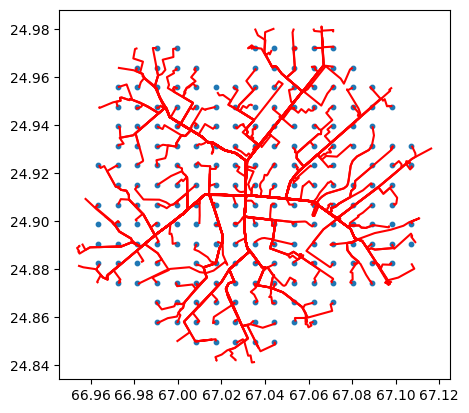

In [21]:
points_df = gpd.GeoDataFrame(karachi_df, geometry=gpd.points_from_xy(karachi_df["dest_lat"], karachi_df["dest_lon"])).set_crs(
    epsg=4326
)
points_inside = gpd.sjoin(points_df, karachi_df_shp, how="inner", op="within")
# points_inside
plt.scatter('dest_lat', 'dest_lon', data = points_inside, s=10)
karachi_df.plot(ax = plt.gca(), edgecolor='red')
# karachi_df
save_plot("routes_with_package")

../figures/14_ameba_with_package.png

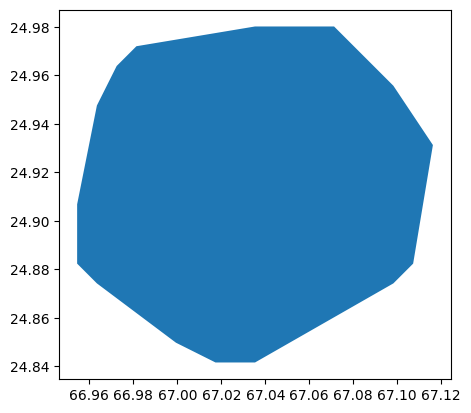

In [22]:
karachi_df_shp.plot()
save_plot("ameba_with_package")

../figures/15_union_routes_shapefile.png


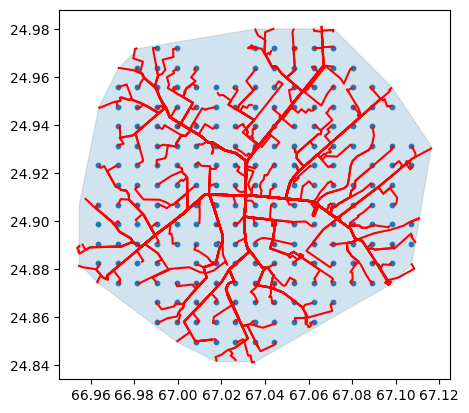

In [23]:
karachi_df_shp.plot(ax=plt.gca(), edgecolor='gray', alpha = 0.2, )
plt.scatter('dest_lat', 'dest_lon', data = points_inside, s=10)
karachi_df.plot(ax = plt.gca(), edgecolor='red')
save_plot("union_routes_shapefile")

<!--  -->
### Cropping the Raster

In this section, we'll demonstrate how to crop a raster file using a shapefile representing the market area.

In [24]:
raster_path = (
    "../data/8_night_light/pk_night_light_harm.tiff"  # Path to the raster file
)
shapefile = karachi_df_shp  # Shapefile representing the market area

# Crop the raster file using the shapefile
with rio.open(raster_path) as src:
    out_image, out_transform = mask(src, getFeatures(shapefile), crop=True)
values = out_image.flatten()
rows, cols = np.indices(out_image.shape[-2:])
x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

# Create a DataFrame with values and coordinates
data = {"x": x, "y": y, "z": values}
df = pd.DataFrame(data)
df

,x,y,z
0,66.958332,24.983334,-3.400000e+38
1,66.966666,24.983334,-3.400000e+38
2,66.974999,24.983334,-3.400000e+38
3,66.983332,24.983334,-3.400000e+38
4,66.991666,24.983334,-3.400000e+38
...,...,...,...
355,67.083332,24.841667,-3.400000e+38
356,67.091666,24.841667,-3.400000e+38
357,67.099999,24.841667,-3.400000e+38
358,67.108332,24.841667,-3.400000e+38


### Filtering Observations within the Shapefile

Next, we'll filter the observations that fall within the boundaries of the shapefile.

In [25]:
points_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"])).set_crs(
    epsg=4326
)
points_inside = gpd.sjoin(points_df, shapefile, how="inner", op="within")
points_inside

,x,y,z,geometry,index_right
26,67.008332,24.975000,61.0,POINT (67.00833 24.97500),0
27,67.016666,24.975000,62.0,POINT (67.01667 24.97500),0
28,67.024999,24.975000,62.0,POINT (67.02500 24.97500),0
29,67.033332,24.975000,63.0,POINT (67.03333 24.97500),0
30,67.041666,24.975000,63.0,POINT (67.04167 24.97500),0
...,...,...,...,...,...
329,67.033332,24.850000,63.0,POINT (67.03333 24.85000),0
330,67.041666,24.850000,63.0,POINT (67.04167 24.85000),0
331,67.049999,24.850000,63.0,POINT (67.05000 24.85000),0
348,67.024999,24.841667,63.0,POINT (67.02500 24.84167),0


Visualize to verify correspondence with the cropped shapefile.

../figures/16_routes_destinations.png


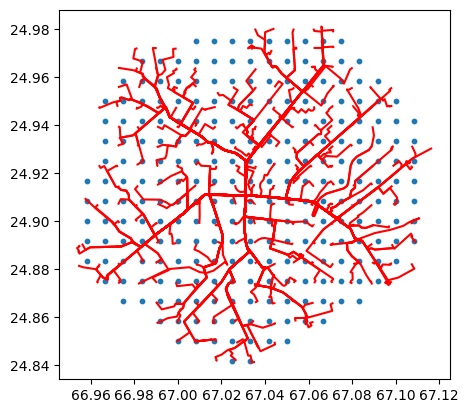

In [26]:

plt.scatter('x', 'y', data = points_inside, s=10)
karachi_df.plot(ax = plt.gca(), edgecolor='red')
save_plot("routes_destinations")

### Metrics

For this case, we'll compute metrics including mean, standard deviation, and sum.

In [27]:
import numpy as np

target_name = "nightlight"

# Define the metrics
metrics = [np.mean, np.std, np.sum]
points_result = points_inside.dropna(subset=["z"])
stats = points_result["z"].agg(metrics).values.flatten()

# Assign computed metrics to the shapefile
(
    shapefile[f"{target_name}_mean"],
    shapefile[f"{target_name}_sd"],
    shapefile[f"{target_name}_sum"],
) = stats
shapefile

,geometry,nightlight_mean,nightlight_sd,nightlight_sum
0,"POLYGON ((67.01737 24.84160, 66.99940 24.84975...",62.848606,0.51477,15775.0


<!--  -->



<!--  -->
### Join All in a Function

To ensure reusability, let's encapsulate the previous procedure into a function that ultimately returns a DataFrame containing the geometry of the shapefile along with its metrics.

In [28]:
def metric_result(
    centroid_from,
    path_raster: str,
    radius_km=4,
    grid_km=1,
    target_name="metrics",
    metrics=[np.mean, np.std, np.sum],
):
    # Generate a shapefile
    routes = areas.get_routes(centroid_from, radius_km=radius_km, grid_km_size=grid_km)
    shapefile = areas.get_ameba(routes, max_km=radius_km)

    # Crop the raster
    with rio.open(path_raster) as src:
        out_image, out_transform = mask(src, getFeatures(shapefile), crop=True)

    values = out_image.flatten()
    rows, cols = np.indices(out_image.shape[-2:])
    x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

    data = {"x": x, "y": y, "z": values}
    df = pd.DataFrame(data)

    # Points inside
    points_df = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df["x"], df["y"])
    ).set_crs(epsg=4326)
    points_inside = gpd.sjoin(points_df, shapefile, how="inner", op="within")

    # Generate Metrics
    points_result = points_inside.dropna(subset=["z"])
    stats = points_result["z"].agg(metrics).values.flatten()

    (
        shapefile[f"{target_name}_mean"],
        shapefile[f"{target_name}_sd"],
        shapefile[f"{target_name}_sum"],
    ) = stats

    return shapefile

Now, let's test it with other coordinates.

In [29]:
centroides_pk = [
    [24.951004, 66.985305],
    [24.910871, 67.030846],
    [24.958856, 67.040013],
    [24.933989, 67.107785],
]

metric_df = gpd.GeoDataFrame()
for centroid in centroides_pk:
    result = metric_result(centroid, path_raster=raster_path)
    metric_df = pd.concat((metric_df, result))

100%|██████████| 64/64 [00:00<00:00, 139.89it/s]


../figures/17_multiples_shapefiles.png


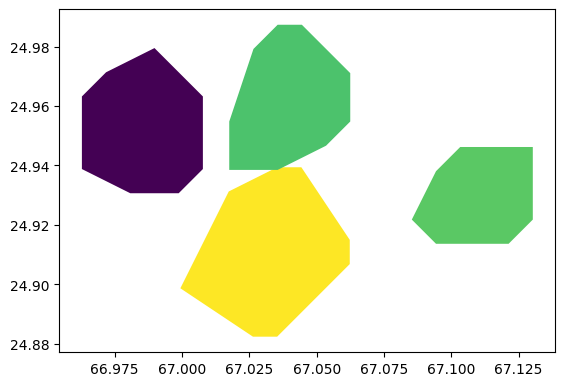

In [30]:
metric_df.plot(column='metrics_mean')
save_plot("multiples_shapefiles")

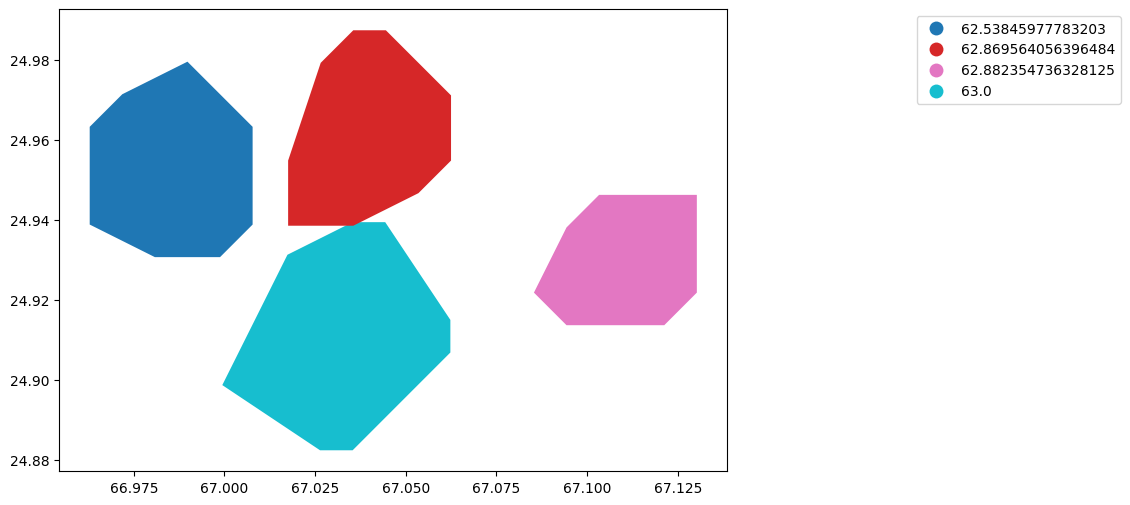

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Supongamos que metric_df es tu GeoDataFrame

# Crear el contenedor de gráficos
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Trazar el mapa con la leyenda
metric_df.plot(column='metrics_mean', legend=True, categorical=True, ax=ax)

# Mover la leyenda fuera del gráfico principal
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.6, 1))

# Mostrar el mapa
plt.show()


In conclusion, to obtain metrics, you need the centroid coordinates, the path to the raster file, the radius of the raster file, the grid width explained in the first part, and lastly, a prefix name for the columns to facilitate merging multiple databases.
<!--  -->



<!--  -->
## Other Metrics 

To streamline the process mentioned earlier, we can use a function that takes the aforementioned parameters as inputs.

In [32]:
def metric_df_calculate(centroids, raster_path, **kwargs):
    metric_df = gpd.GeoDataFrame()
    for centroid in centroids:
        result = metric_result(centroid, raster_path, **kwargs)
        metric_df = pd.concat((metric_df, result))
    return metric_df

### Nightlight

#### Harm 

Nightlight data can provide insights into urbanization and economic activity. Let's calculate metrics for the "Harm" version of nightlight data.

In [33]:
r_path = "../data/8_night_light/pk_night_light_harm.tiff"
name_col = "nightlight_harm"
metric_df_calculate(centroides_pk, raster_path=r_path, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 137.29it/s]


,geometry,nightlight_harm_mean,nightlight_harm_sd,nightlight_harm_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",62.538460,0.706018,1626.0
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",63.000000,0.000000,2079.0
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",62.869564,0.344350,1446.0
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",62.882355,0.332106,1069.0


#### Original

Now, let's compute metrics for the original nightlight data.

In [34]:
r_path = '../data/8_night_light/pk_night_light.tiff'
name_col = "nightlight"
metric_df_calculate(centroides_pk, raster_path = r_path, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 136.62it/s]


,geometry,nightlight_mean,nightlight_sd,nightlight_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",37.389423,9.111515,3551.995361
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",45.842979,8.936888,6051.273438
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",41.734932,13.678473,3714.408936
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",33.580753,8.758814,2451.395020


### Population

Population density is a crucial indicator for various analyses. Let's calculate metrics based on population data.

In [35]:
pop_tif = "../data/1_density/pak_ppp_2018_1km_Aggregated.tif"
name_col = "population"
metric_df_calculate(centroides_pk, pop_tif, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 139.25it/s]


,geometry,population_mean,population_sd,population_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",8332.324219,1757.787231,1.916435e+05
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",40848.847656,11281.851562,1.348012e+06
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",29824.935547,15117.108398,7.754483e+05
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",20428.244141,8269.201172,3.881366e+05


### Motor

Friction surfaces, such as motorized friction, can indicate the ease of travel. Let's analyze motorized friction data.

In [36]:
motor_tif = "../data/5_friction_surface/2020_motorized_friction_surface.geotiff"
motor_name = "motor"
metric_df_calculate(centroides_pk, motor_tif, target_name=motor_name)

100%|██████████| 64/64 [00:00<00:00, 136.58it/s]


,geometry,motor_mean,motor_sd,motor_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",0.00093,0.000196,0.0214
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",0.00080,0.000217,0.0264
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",0.00110,0.000227,0.0231
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",0.00092,0.000154,0.0184


### Altitude

Altitude data provides valuable insights into terrain characteristics. Let's compute altitude metrics.

In [37]:
srtm_tif = "../data/6_srtm/PK_srtm.tif"
name_col = "altitude"
metric_df_calculate(centroides_pk, srtm_tif, target_name=name_col)

# metric_df_areas.to_file("../sample_data/geometries.shp")

100%|██████████| 64/64 [00:00<00:00, 125.00it/s]


,geometry,altitude_mean,altitude_sd,altitude_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",64.127129,11.175416,161921.0
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",25.073862,6.582567,83170.0
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",63.665825,15.961967,151461.0
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",44.649883,7.974960,77155.0


These functions allow for efficient computation of various metrics, providing valuable information for spatial analysis and decision-making.
<!--  -->

## Summary Table - Islamabad


In [38]:
from osrmareas import areas
crd = [33.684091, 73.045315]
islamabad = areas.get_routes(crd, 30)
islamabad_area = areas.get_ameba(islamabad, 30)#.to_file("../sample_data/")

islamabad_area['coord'] = 'islamabad'
islamabad_area = pd.concat((islamabad_area, islamabad_area))
islamabad_area.to_file("../sample_data/geometries_isla.shp")

100%|██████████| 3600/3600 [00:42<00:00, 84.33it/s] 


In [39]:
pk_ookla = gpd.read_file("../data/9_internet_speed/0_pakistan_okkla.shp")

islamabad_ookla = gpd.sjoin(pk_ookla, islamabad_area, op='within')

In [40]:
def calculate_metric(df, col, name, metrics = [np.mean, np.std, np.sum]):
    stats = df[col].agg(metrics).values.flatten()
    result = {
        "Name": [name],
        "Mean": [stats[0]],
        "STD": [stats[1]],
        "Sum": [stats[2]]
    }
    result =  pd.DataFrame(result)
    return result

def simple_metric(path_raster, shapefile, name):
    with rio.open(path_raster) as src:
        out_image, out_transform = mask(src, getFeatures(shapefile), crop=True)

    values = out_image.flatten()
    rows, cols = np.indices(out_image.shape[-2:])
    x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

    data = {"x": x, "y": y, "z": values}
    df = pd.DataFrame(data)

    # Points inside
    points_df = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df["x"], df["y"])
    ).set_crs(epsg=4326)
    points_inside = gpd.sjoin(points_df, shapefile, how="inner", op="within")

    # Generate Metrics
    points_result = points_inside.dropna(subset=["z"])
    result = calculate_metric(points_result, 'z', name)

    return result

internet_d = calculate_metric(islamabad_ookla, 'avg_d_kbps', 'Internet Speed (kbps) - Download')
internet_u = calculate_metric(islamabad_ookla, 'avg_u_kbps', 'Internet Speed (kbps) - Upload')
_raster_paths = [
    '../data/8_night_light/pk_night_light_harm.tiff',
    '../data/8_night_light/pk_night_light.tiff',
    '../data/1_density/pak_ppp_2018_1km_Aggregated.tif',
    '../data/5_friction_surface/2020_motorized_friction_surface.geotiff',
    '../data/6_srtm/PK_srtm.tif'
]

_raster_names = [
    "Night Light - Harm"
    ,"Night Light"
    ,"Population 1km"
    ,"Motor Friction"
    ,"Altitude"
]

all_metrics = pd.DataFrame()
for _raster, _names in zip(_raster_paths, _raster_names):
    _result = simple_metric(_raster, islamabad_area, _names)
    all_metrics = pd.concat((_result, all_metrics))
all_metrics = pd.concat((all_metrics, internet_d))
all_metrics = pd.concat((all_metrics, internet_u))
all_metrics.round(5)

,Name,Mean,STD,Sum
0,Altitude,603.92212,177.74220,2.267764e+08
0,Motor Friction,0.00483,0.01028,1.814857e+01
0,Population 1km,2082.30664,3382.38989,7.816979e+06
0,Night Light,5.90667,8.33449,8.880095e+04
0,Night Light - Harm,33.05011,19.03126,1.240040e+05
0,Internet Speed (kbps) - Download,8700.69637,6124.62904,3.495940e+07
0,Internet Speed (kbps) - Upload,7338.59781,6896.70205,2.948649e+07



## Plot Raster

In [41]:
import geopandas as gpd, numpy as np
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [42]:
# Aditional 

crd = [33.684091, 73.045315]
islamabad = areas.get_routes(crd, 30)
islamabad_area = areas.get_ameba(islamabad, 30)#.to_file("../sample_data/")


100%|██████████| 3600/3600 [00:42<00:00, 83.95it/s] 


In [43]:

islamabad_area['coord'] = 'islamabad'
islamabad_area = pd.concat((islamabad_area, islamabad_area))
islamabad_area.to_file("../sample_data/geometries_isla.shp")

### Altitude

../figures/18_karachi_altitude.png


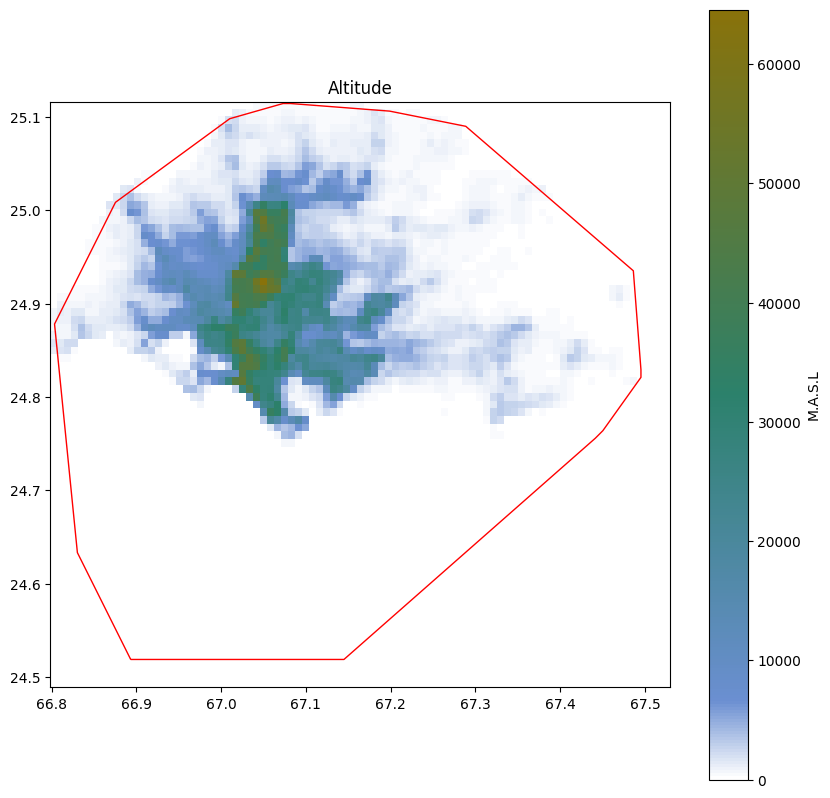

In [44]:
tiff_sample="../data/1_density/pak_ppp_2018_1km_Aggregated.tif"
out_raster="../sample_data/out_raster/altitude.tif"
title_raster="Altitude"
t_label="M.A.S.L"
map_color_hex=("#6B8FD1", "#2C816B", "#89720A")
none_data=0
shp_sample="../sample_data/geometries.shp"

c1, c2, c3 = map_color_hex
map_color = [(0.0, "white"), (0.1, c1), (0.5, c2), (1.0, c3)]
cmap_vals = sorted(map_color, key=lambda x: x[0])  # Ordenar cmap_vals en orden ascendente

gdf = gpd.read_file(shp_sample).iloc[1:2]

with rasterio.open(tiff_sample) as src:
    out_image, out_transform = mask(
        src, gdf.geometry, crop=True, nodata=none_data, all_touched=True
    )

    # Obtener la transformación inversa para convertir las coordenadas de píxeles a coordenadas geográficas
    out_meta = src.meta.copy()
    out_meta.update(
        {
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
        }
    )
    inv_transform = out_transform

with rasterio.open(out_raster, "w", **out_meta) as dest:
    dest.write(out_image)

cmap = LinearSegmentedColormap.from_list("custom", cmap_vals)

with rasterio.open(out_raster) as raster:
    data = raster.read(1)
    nodata_value = raster.nodata

    data = np.where(data == nodata_value, np.nan, data)

    # Transformar las coordenadas del raster a coordenadas geográficas
    height, width = data.shape
    xs = np.arange(0, width) * inv_transform.a + inv_transform.xoff
    ys = np.arange(0, height) * inv_transform.e + inv_transform.yoff

    plt.figure(figsize=(10, 10))
    plt.imshow(data, extent=[xs[0], xs[-1], ys[-1], ys[0]], cmap=cmap)
    plt.title(title_raster)
    plt.colorbar(label=t_label)

    # Plotear el shapefile
    gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

    save_plot("karachi_altitude")
    plt.show()

../figures/19_altitude-karachi.png


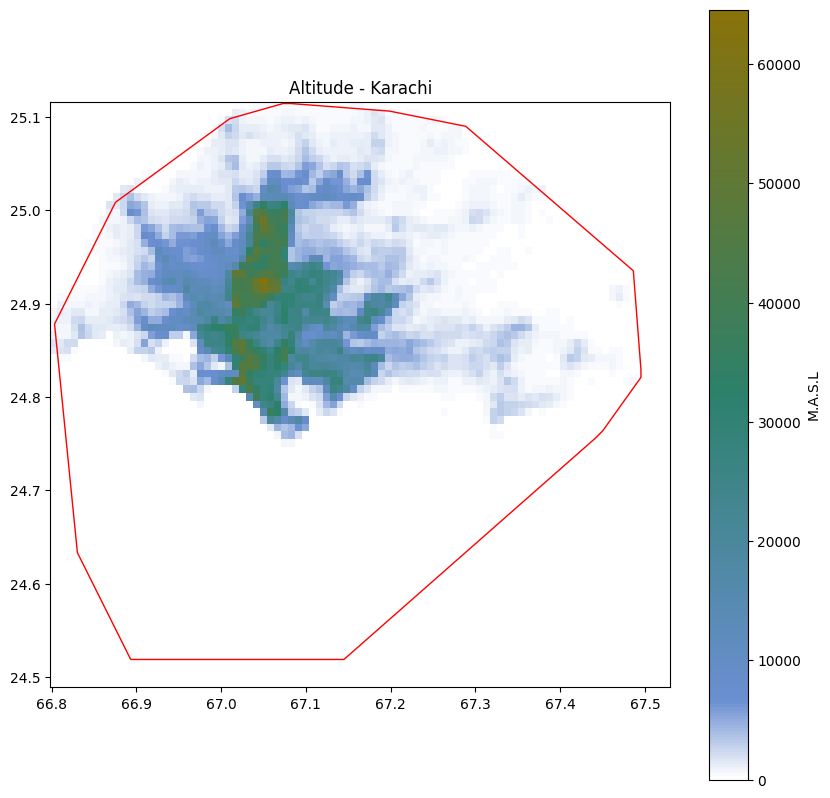

In [45]:
# convert into a function
def gen_plot(
    name = '',
    tiff_sample="../data/1_density/pak_ppp_2018_1km_Aggregated.tif",
    out_raster="../sample_data/out_raster/altitude.tif",
    title_raster="Altitude - Karachi",
    t_label="M.A.S.L",
    map_color_hex=("#6B8FD1", "#2C816B", "#89720A"),
    none_data=0,
    shp_sample="../sample_data/geometries.shp",
):

    c1, c2, c3 = map_color_hex
    map_color = [(0.0, "white"), (0.1, c1), (0.5, c2), (1.0, c3)]
    cmap_vals = sorted(map_color, key=lambda x: x[0])  # Ordenar cmap_vals en orden ascendente

    gdf = gpd.read_file(shp_sample).iloc[1:2]

    with rasterio.open(tiff_sample) as src:
        out_image, out_transform = mask(
            src, gdf.geometry, crop=True, nodata=none_data, all_touched=True
        )

        # Obtener la transformación inversa para convertir las coordenadas de píxeles a coordenadas geográficas
        out_meta = src.meta.copy()
        out_meta.update(
            {
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
            }
        )
        inv_transform = out_transform

    with rasterio.open(out_raster, "w", **out_meta) as dest:
        dest.write(out_image)

    cmap = LinearSegmentedColormap.from_list("custom", cmap_vals)

    with rasterio.open(out_raster) as raster:
        data = raster.read(1)
        nodata_value = raster.nodata

        data = np.where(data == nodata_value, np.nan, data)

        # Transformar las coordenadas del raster a coordenadas geográficas
        height, width = data.shape
        xs = np.arange(0, width) * inv_transform.a + inv_transform.xoff
        ys = np.arange(0, height) * inv_transform.e + inv_transform.yoff

        plt.figure(figsize=(10, 10))
        plt.imshow(data, extent=[xs[0], xs[-1], ys[-1], ys[0]], cmap=cmap)
        plt.title(title_raster)
        plt.colorbar(label=t_label)

        # Plotear el shapefile
        gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

        save_plot(name)
        
        plt.show()


gen_plot("altitude-karachi")

../figures/20_altitude_islamabad.png


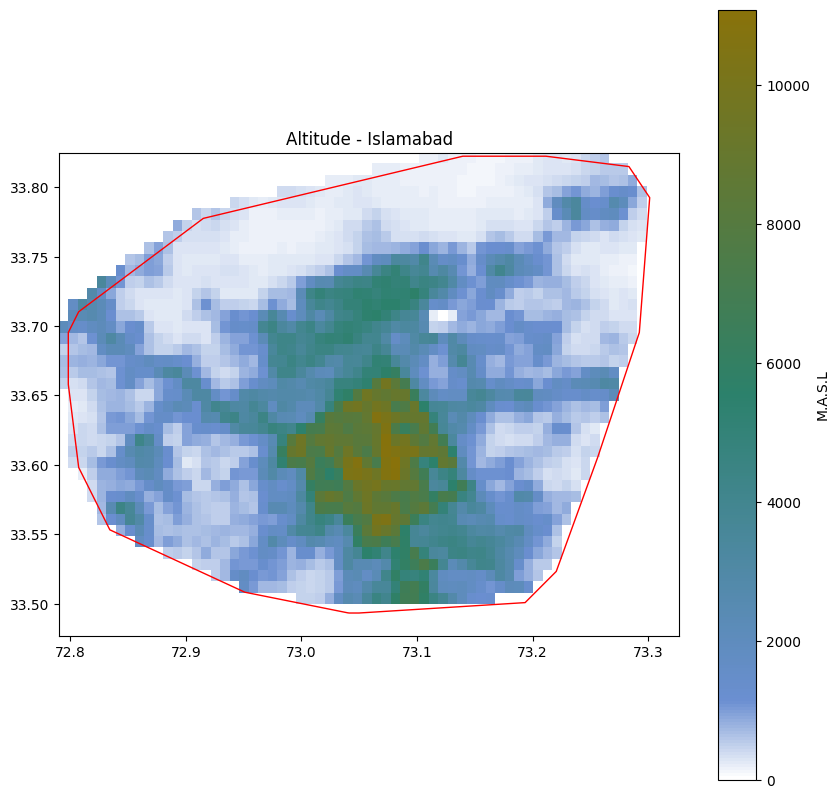

In [46]:
# islamabad
isla_name = "Islamabad"
islamabad_shp = '../sample_data/geometries_isla.shp'

gen_plot("altitude_islamabad",shp_sample=islamabad_shp, title_raster=f"Altitude - {isla_name}")

### Motor Friction

../figures/21_friction_surface_karachi.png


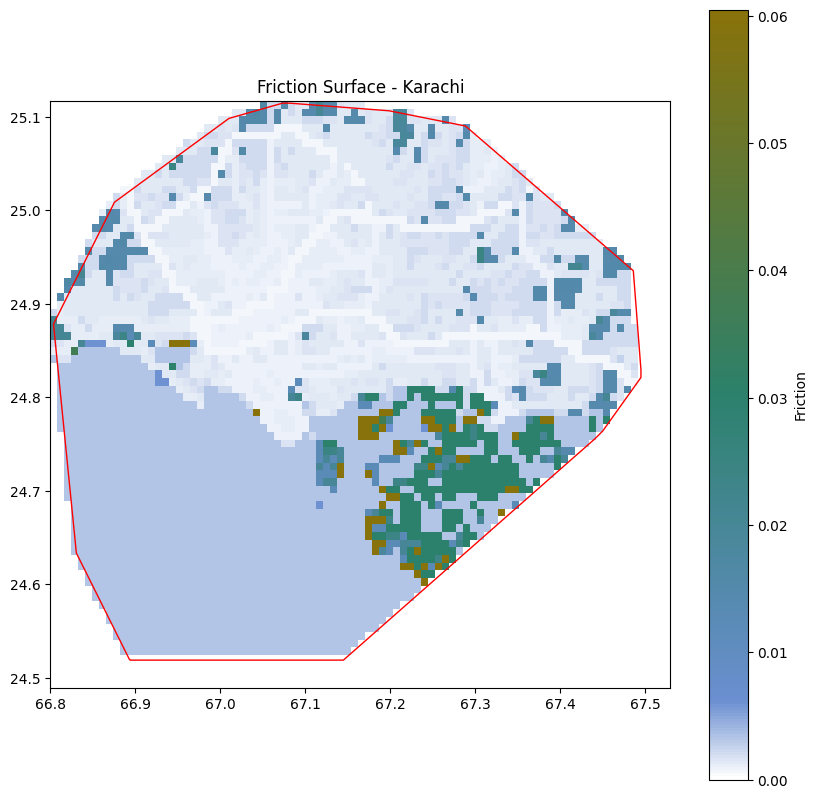

In [47]:
gen_plot(
    "friction_surface_karachi",
    tiff_sample="../data/5_friction_surface/2020_motorized_friction_surface.geotiff",
    out_raster="../sample_data/out_raster/motor.tif",
    title_raster="Friction Surface - Karachi",
    t_label="Friction",
    map_color_hex=("#6B8FD1", "#2C816B", "#89720A"),
    none_data=0,
    shp_sample="../sample_data/geometries.shp",
)

../figures/22_friction_surface_islamabad.png


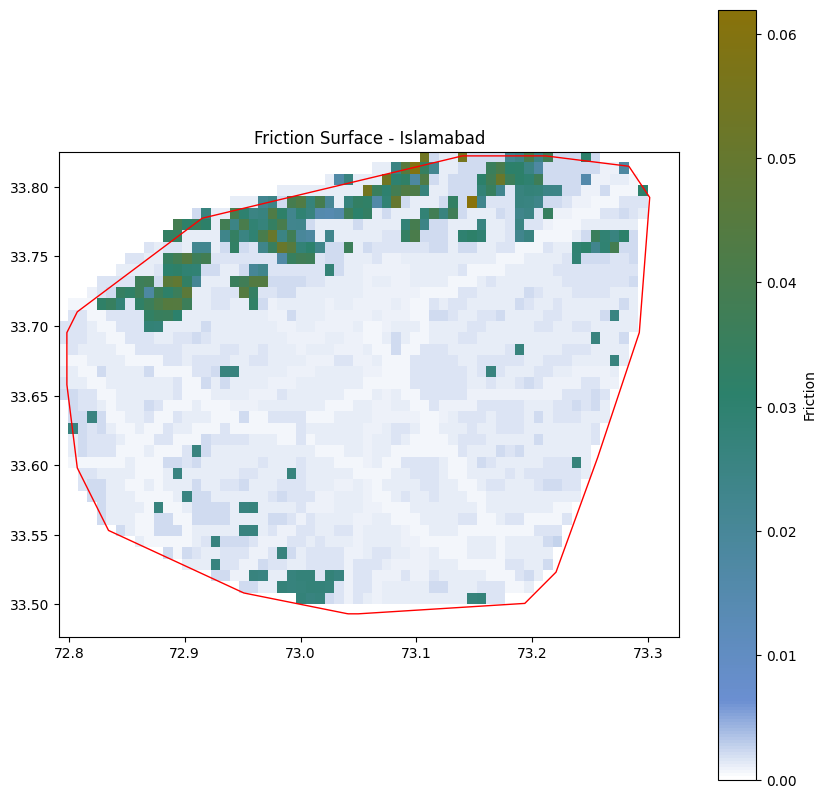

In [48]:
gen_plot(
    "friction_surface_islamabad",
    tiff_sample="../data/5_friction_surface/2020_motorized_friction_surface.geotiff",
    out_raster="../sample_data/out_raster/motor.tif",
    title_raster=f"Friction Surface - {isla_name}",
    t_label="Friction",
    map_color_hex=("#6B8FD1", "#2C816B", "#89720A"),
    none_data=0,
    shp_sample=islamabad_shp
)

### Night Light 

../figures/23_karachi_nightlight.png


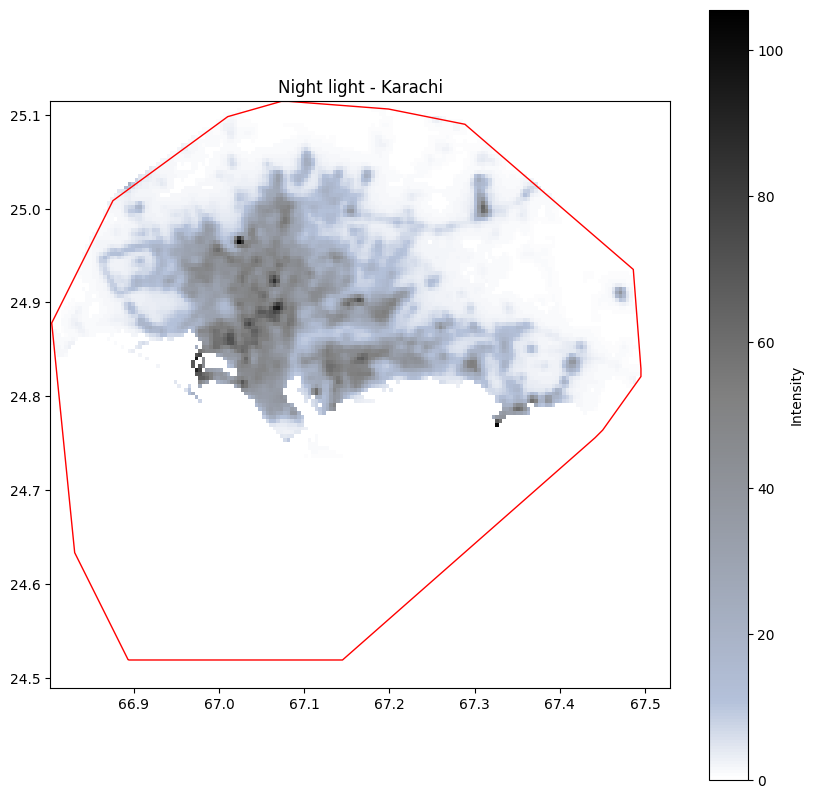

In [49]:
gen_plot(
    "karachi_nightlight",
    tiff_sample="../data/8_night_light/pk_night_light.tiff",
    out_raster="../sample_data/out_raster/night_light.tif",
    title_raster="Night light - Karachi",
    t_label="Intensity",
    map_color_hex=("#B4C1DA", "gray", "black"),
    none_data=0,
    shp_sample="../sample_data/geometries.shp",
)

../figures/24_islamabad_nightlight.png


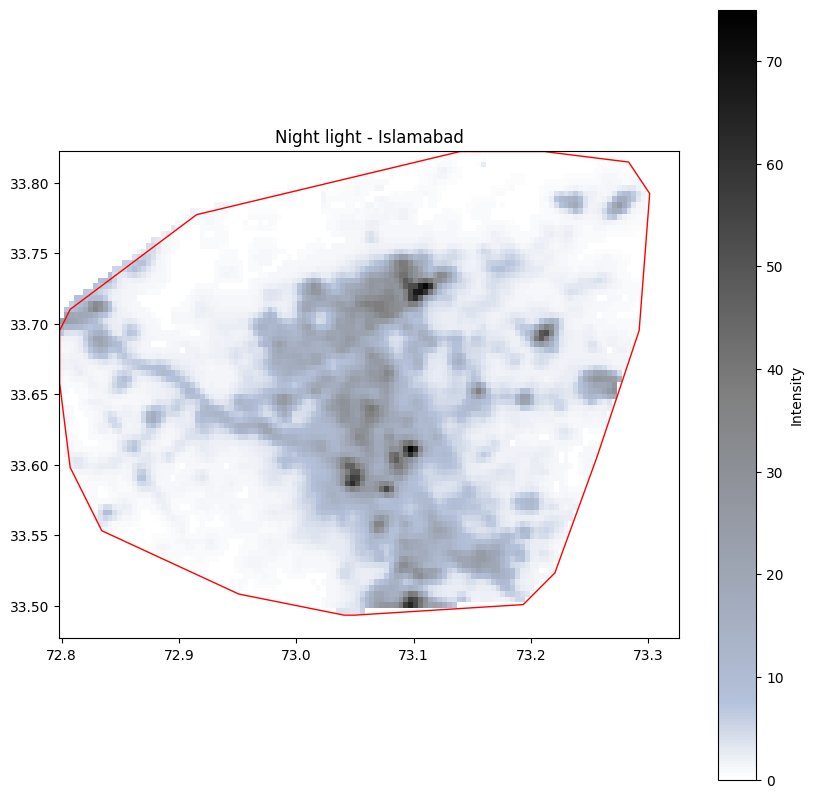

In [50]:
gen_plot(
    "islamabad_nightlight",
    tiff_sample="../data/8_night_light/pk_night_light.tiff",
    out_raster="../sample_data/out_raster/night_light.tif",
    title_raster=f"Night light - {isla_name}",
    t_label="Intensity",
    map_color_hex=("#B4C1DA", "gray", "black"),
    none_data=0,
    shp_sample=islamabad_shp
)

### Night Light - Harmonize

../figures/25_karachi_nightlight_harm.png


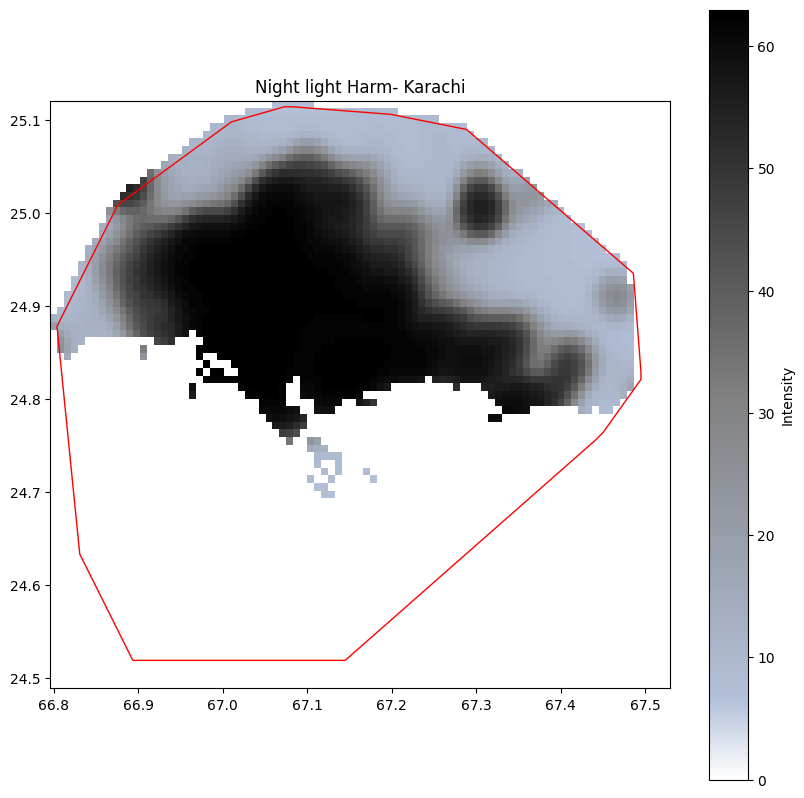

In [51]:
gen_plot(
    "karachi_nightlight_harm",
    tiff_sample="../data/8_night_light/pk_night_light_harm.tiff",
    out_raster="../sample_data/out_raster/night_light_harm.tif",
    title_raster=f"Night light Harm- Karachi",
    t_label="Intensity",
    map_color_hex=("#B4C1DA", "gray", "black"),
    none_data=0,
    shp_sample="../sample_data/geometries.shp",
)

../figures/26_islamabad_nightlight_harm.png


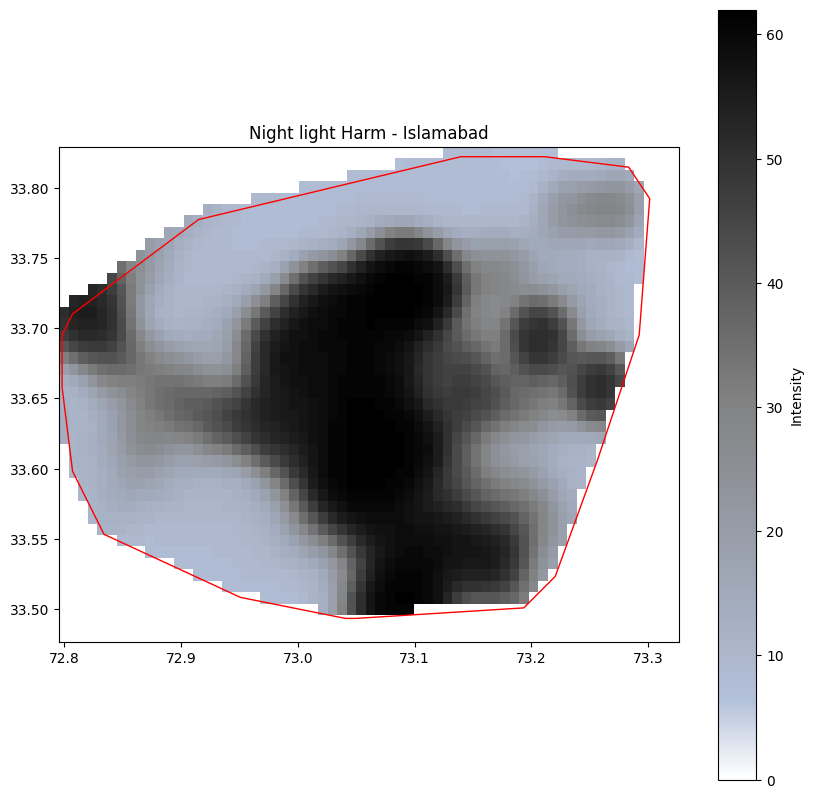

In [52]:
gen_plot(
    "islamabad_nightlight_harm",
    tiff_sample="../data/8_night_light/pk_night_light_harm.tiff",
    out_raster="../sample_data/out_raster/night_light_harm.tif",
    title_raster=f"Night light Harm - {isla_name}",
    t_label="Intensity",
    map_color_hex=("#B4C1DA", "gray", "black"),
    none_data=0,
    shp_sample=islamabad_shp
)


### Population


../figures/27_karachi_population.png


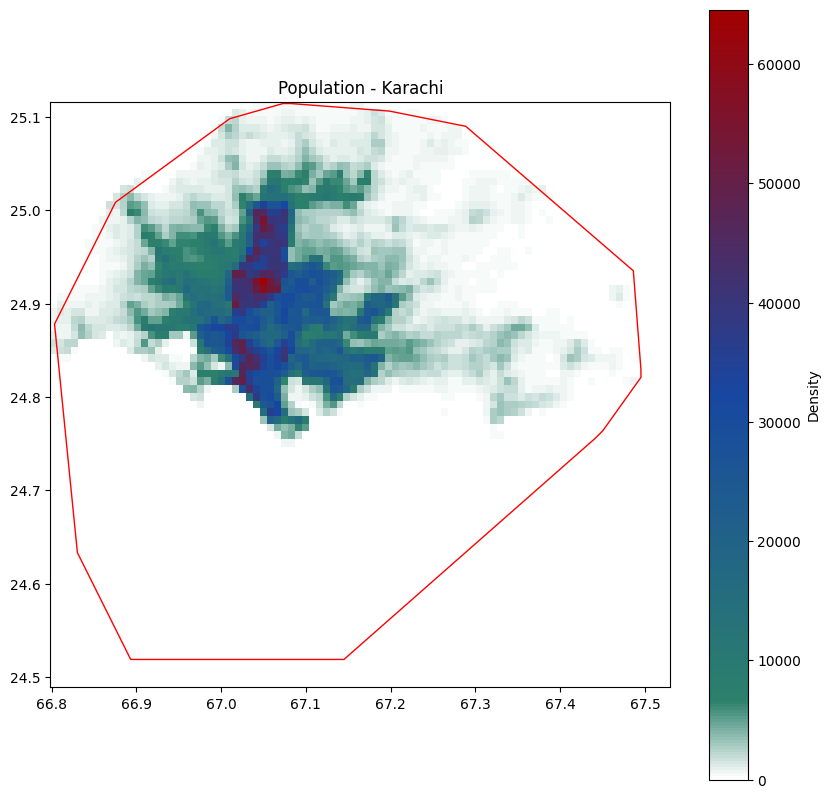

In [53]:
gen_plot(
    "karachi_population",
    tiff_sample="../data/1_density/pak_ppp_2018_1km_Aggregated.tif",
    out_raster="../sample_data/out_raster/population.tif",
    title_raster="Population - Karachi",
    t_label="Density",
    map_color_hex=("#2C816B", "#1747A1", "#A30000"),
    none_data=0,
    shp_sample="../sample_data/geometries.shp",
)

../figures/28_islamabad-population.png


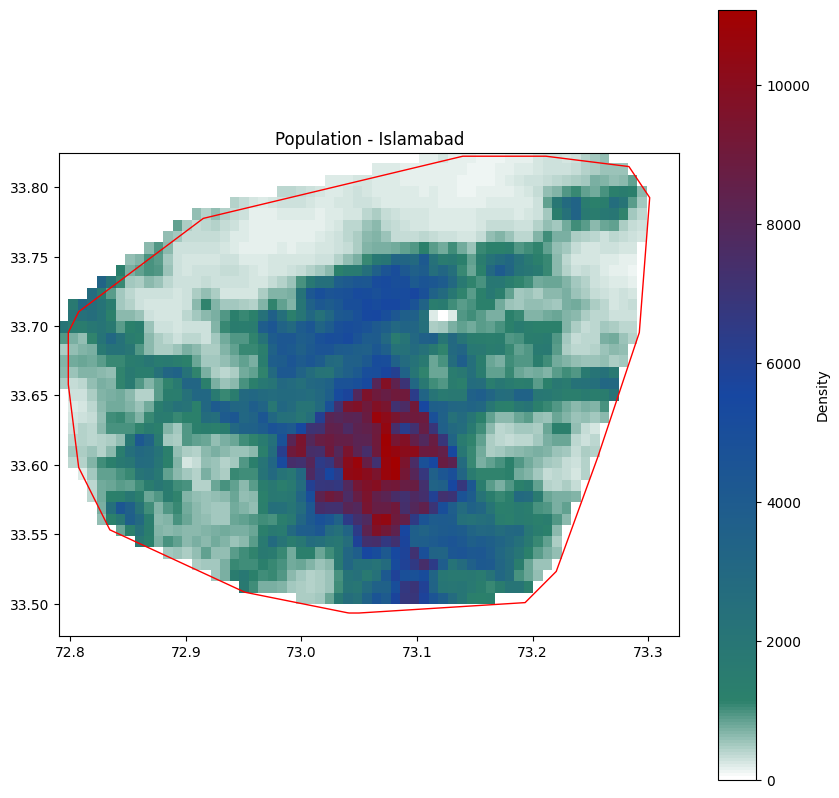

In [54]:
gen_plot(
    "islamabad-population",
    tiff_sample="../data/1_density/pak_ppp_2018_1km_Aggregated.tif",
    out_raster="../sample_data/out_raster/population.tif",
    title_raster=f"Population - {isla_name}",
    t_label="Density",
    map_color_hex=("#2C816B", "#1747A1", "#A30000"),
    none_data=0,
    shp_sample=islamabad_shp
)

### Internet Speed - Download

../figures/29_islamabad_download_speed.png


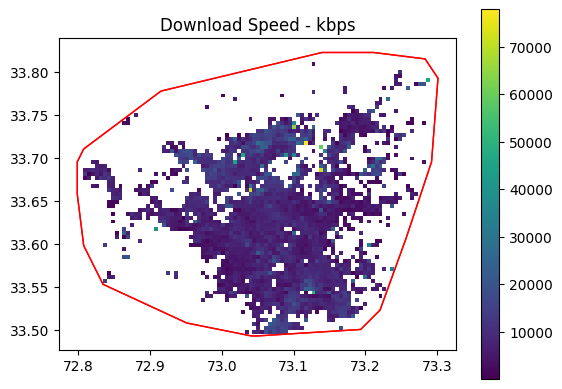

In [55]:
islamabad_ookla.plot(column='avg_d_kbps', legend=True)
islamabad_area.plot(ax=plt.gca(), edgecolor = 'red', facecolor = 'none')
plt.title("Download Speed - kbps")
save_plot("islamabad_download_speed")

### Internet Speed - Upload

../figures/30_islamabad_download_speed.png


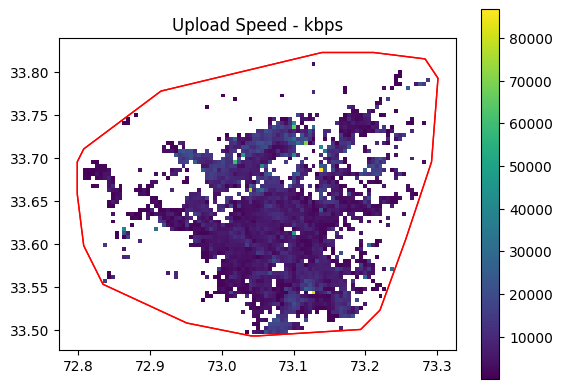

In [56]:
islamabad_ookla.plot(column='avg_u_kbps', legend=True)
islamabad_area.plot(ax=plt.gca(), edgecolor = 'red', facecolor = 'none')
plt.title("Upload Speed - kbps")
save_plot("islamabad_download_speed")

### GHS - Settlement

#### Adding Functions

In [57]:
labels = {
    1 : "1: MSZ, open spaces, low vegetation surfaces NDVI <= 0.3",
    2 : "2: MSZ, open spaces, medium vegetation surfaces 0.3 < NDVI <=0.5",
    3 : "3: MSZ, open spaces, high vegetation surfaces NDVI > 0.5",
    4 : "4: MSZ, open spaces, water surfaces LAND < 0.5",
    5 : "5: MSZ, open spaces, road surfaces",
    11: "11: MSZ, built spaces, residential, building height <= 3m",
    12: "12: MSZ, built spaces, residential, 3m < building height <= 6m",
    13: "13: MSZ, built spaces, residential, 6m < building height <= 15m",
    14: "14: MSZ, built spaces, residential, 15m < building height <= 30m",
    15: "15: MSZ, built spaces, residential, building height > 30m",
    21: "21: MSZ, built spaces, non-residential, building height <= 3m",
    22: "22: MSZ, built spaces, non-residential, 3m < building height <= 6m",
    23: "23: MSZ, built spaces, non-residential, 6m < building height <= 15m",
    24: "24: MSZ, built spaces, non-residential, 15m < building height <= 30m",
    25: "25: MSZ, built spaces, non-residential, building height > 30m"
}

from matplotlib.colors import LinearSegmentedColormap
def crop_messy_raster(
        raster_path:str, 
        shapefile_path:str, 
        out_raster_file:str, 
        shapefile = None,
        ):
    if shapefile:
        gdf = shapefile
    else:
        gdf = gpd.read_file(shapefile_path)

    with rasterio.open(raster_path) as raster:
        crs_raster = raster.crs.to_dict()
        gdf_raster_proj = gdf.to_crs(crs_raster)
        raster_cropped, transformation = mask(
            raster, gdf_raster_proj.geometry, crop=True
        )

        meta = raster.meta.copy()
        meta.update({
            "driver": "GTiff",
            "height": raster_cropped.shape[1],
            "width": raster_cropped.shape[2],
            "transform": transformation,
            "crs": crs_raster 
        })

    with rasterio.open(out_raster_file, "w", **meta) as dest:
        dest.write(raster_cropped)
    return transformation, raster_cropped

def raster_to_data(raster_cropped, transformation):
    values = raster_cropped.flatten()
    rows, cols = np.indices(raster_cropped.shape[-2:])
    x, y = rasterio.transform.xy(transformation, rows.flatten(), cols.flatten())

    data = {"x": x, "y": y, "z": values}
    df = pd.DataFrame(data)
    return df
    

def plot_raster(
    raster_name: str
    , transformation_data
    , original_shp_path = None
    , name_plot = "settlement_islamabad"
    , original_shp = None
    , map_color_hex=(
        "#b2edc2", "#0eb33b", 
        "#102985", 
        "#cfb38f", 
        "#c579d1", "#581363",
        "#c1f4f5", "#038f91"
        )
    , break_points =  [
        0, 0.2,
        0.20, 
        0.3, 
        0.39, 0.66,
        0.70, 1
    ]
):

    if original_shp:
        gdf = original_shp
    else:
        gdf = gpd.read_file(original_shp_path)
    
    map_color = [(bp, col) for bp, col in zip(break_points, map_color_hex)]
    # map_color = [()
        
    #     (0.0, c0), (0.1, c1), (0.5, c2), (1.0, c3)]
    cmap_vals = sorted(map_color, key=lambda x: x[0])  
    # print(map_color)
    cmap = LinearSegmentedColormap.from_list("custom", cmap_vals)

    with rasterio.open(raster_name) as raster:
        data = raster.read(1)
        nodata_value = raster.nodata
        crs = raster.crs.to_dict()
        gdf_raster = gdf.to_crs(crs)
        data = np.where(data == nodata_value, np.nan, data)
        height, width = data.shape
        inv_transform = transformation_data
        xs = np.arange(0, width) * inv_transform.a + inv_transform.xoff
        ys = np.arange(0, height) * inv_transform.e + inv_transform.yoff
        plt.figure(figsize=(4, 4))
        plt.imshow(data, extent=[xs[0], xs[-1], ys[-1], ys[0]], cmap=cmap)
        # plt.title("Islamabad - Settlement")

        # ################
        # replace = 
        legend_labels = list(labels.values())
        legend_colors = [plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(labels.keys()), vmax=max(labels.keys()))).to_rgba(key) for key in labels.keys()]

        plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)], loc='center left', bbox_to_anchor=(1, 0.5))
        # ########### 

        
        gdf_raster.plot(ax=plt.gca(), edgecolor='red', facecolor='none')
        # The line `# plt.colorbar(label='Settlement', ticks=ticks_values)` is a commented-out line of code in the script. If you were to uncomment this line, it would add a colorbar to the plot generated by `plt.imshow(data, cmap=cmap)`.
        # plt.colorbar(label='Settlement')
        save_plot(name_plot)

        plt.show()

def summary_settlement(df: pd.DataFrame, names_settlement  = ['Value', "Count", "Percent %"]):
    data_settle = df.query('z > 0 & z < 100').value_counts('z').reset_index().sort_values('z')
    data_settle['percent'] = data_settle['count'] / sum(data_settle['count']) * 100 
    data_settle = data_settle.round(2)
    data_settle['percent'] = data_settle['percent'].astype(str) + " %"
    data_settle.columns = names_settlement
    data_settle['Value'] = data_settle['Value'].replace(labels)

    return data_settle

In [58]:
settle_raster = '../data/2_setlement/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0.tif'
pk_geometry = "../sample_data/geometries_isla.shp"
out_test_raster = '../tutorials/data-pbf/test.tif'

100%|██████████| 484/484 [00:04<00:00, 110.78it/s]


../figures/31_latlong_shapefile.png


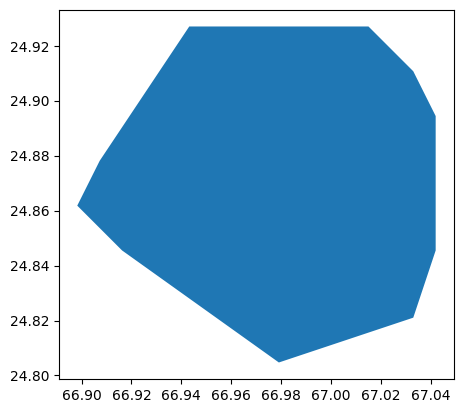

In [59]:
from osrmareas import areas
where = [24.862616173493297, 66.98000942531286]
km = 10.6
_df = areas.get_routes(where, km)
_shp = areas.get_ameba(_df, max_km = km)
_shp.plot()
# _shp.to_file(pk_geometry)
save_plot("latlong_shapefile")

../figures/32_mollwide_shapefile.png


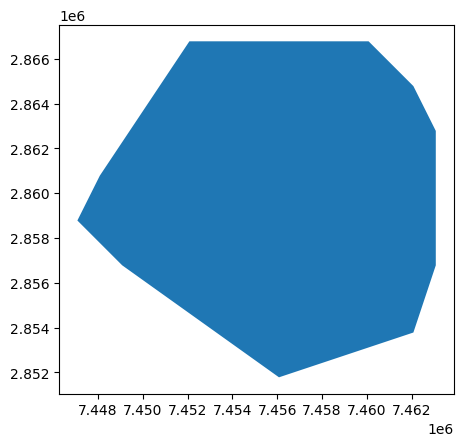

In [60]:
_shp.to_crs(crs_moll).plot()
save_plot("mollwide_shapefile")

../figures/33_settlement_islamabad.png


<Figure size 2000x2000 with 0 Axes>

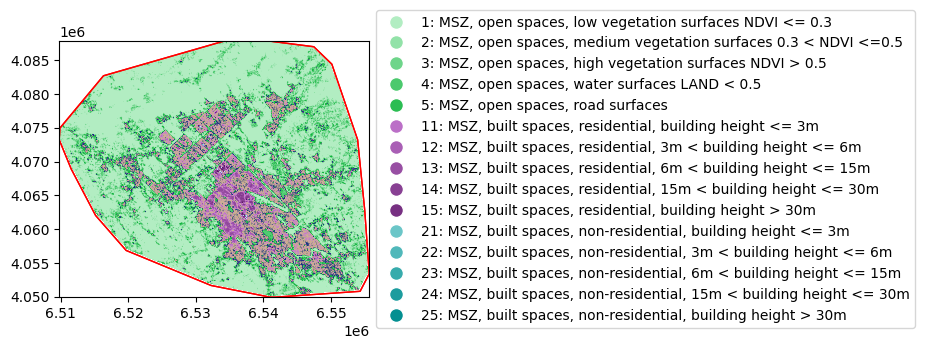

In [61]:
transformation, cropped = crop_messy_raster(settle_raster, pk_geometry, out_test_raster)
plt.figure(figsize=(20, 20))
plot_raster(out_test_raster, transformation, pk_geometry)

In [62]:
df = raster_to_data(cropped, transformation)
df.head()

,x,y,z
0,6509775.0,4087865.0,255
1,6509785.0,4087865.0,255
2,6509795.0,4087865.0,255
3,6509805.0,4087865.0,255
4,6509815.0,4087865.0,255


In [66]:
summary = summary_settlement(df)
summary

,Value,Count,Percent %
2,"1: MSZ, open spaces, low vegetation surfaces N...",610582,14.26 %
1,"2: MSZ, open spaces, medium vegetation surface...",753567,17.6 %
3,"3: MSZ, open spaces, high vegetation surfaces ...",584688,13.66 %
11,"4: MSZ, open spaces, water surfaces LAND < 0.5",3582,0.08 %
7,"5: MSZ, open spaces, road surfaces",102069,2.38 %
4,"11: MSZ, built spaces, residential, building h...",381063,8.9 %
5,"12: MSZ, built spaces, residential, 3m < build...",242257,5.66 %
0,"13: MSZ, built spaces, residential, 6m < build...",1375630,32.13 %
6,"14: MSZ, built spaces, residential, 15m < buil...",178002,4.16 %
13,"15: MSZ, built spaces, residential, building h...",267,0.01 %
